# Distributed alternating direction method of multipliers (ADMM)

In [30]:
import os
import json
import math
from oedisi.types.data_types import MeasurementArray, AdmittanceMatrix, Topology
import pyarrow.feather as feather
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import glob
from oedisi.componentframework.system_configuration import (
    WiringDiagram,
    Component,
    Link,
)

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
BUILDS = f"{ROOT}/builds"
SCENARIOS = f"{ROOT}/scenarios"

## Select a scenario
Set the SCENARIOS index value from the available scenarios

In [31]:
dir = []
def list_files_scandir(path="."):
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                if "system.json" in entry.path:
                    path, _ = entry.path.split("system.json", 1)
                    dir.append(path)
            elif entry.is_dir():
                list_files_scandir(entry.path)


# Specify the directory path you want to start from
directory_path = f"{SCENARIOS}/lindistflow"
list_files_scandir(directory_path)
for i, d in enumerate(dir):
    print(i, d)

0 /home/tylor/oedisi_dopf/scenarios/lindistflow/ieee123/
1 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P9U/low/
2 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P9U/high/
3 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P9U/extreme/
4 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P9U/medium/
5 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P1U/low/
6 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P1U/high/
7 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P1U/extreme/
8 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P1U/medium/
9 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P6U/low/
10 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P6U/high/
11 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P6U/extreme/
12 /home/tylor/oedisi_dopf/scenarios/lindistflow/SFO/P6U/medium/


## Build the selected scenario
The build will create a new build_<scenario> folder and copy over the federate files as specified. Assume successful build if no errors are presented.

In [32]:
index = 0
path = dir[index]
_, scenario = path.split(SCENARIOS, 1)
build = f"{BUILDS}{scenario}"
output = f"{OUTPUTS}{scenario}"

## Model Topology
split model into areas using discconnection switches

In [63]:
topology_file = f"{output}/topology.json"
with open(topology_file) as f:
    topology = Topology.parse_obj(json.load(f))

In [83]:
import lindistflow_federate.adapter as ada
import copy

def get_system(path: str) -> WiringDiagram:
    with open(path) as f:
        system: WiringDiagram = WiringDiagram.parse_obj(json.load(f))
    return system

slack_bus, _ = topology.slack_bus[0].split(".", 1)

G = ada.generate_graph(topology.incidences, slack_bus)
print("Total: ", G)
graph = copy.deepcopy(G)
graph2 = copy.deepcopy(G)
boundaries = ada.area_disconnects(graph)
areas = ada.disconnect_areas(graph2, boundaries)
areas = ada.reconnect_area_switches(areas, boundaries)

for area in areas:
    print(area)
    src = []
    for u, v, a in boundaries:
        if area.has_edge(u, v):
            print("\t", a["id"])
            src.append((u, v, a))
    su, sv, sa = ada.get_area_source(G, slack_bus, src)
    print("\tsource: ", sa["id"])

Total:  Graph with 130 nodes and 129 edges
Graph with 42 nodes and 41 edges
	 sw2
	 sw3
	source:  sw2
Graph with 20 nodes and 19 edges
	 sw3
	source:  sw3
Graph with 20 nodes and 19 edges
	 sw2
	 sw4
	source:  sw2
Graph with 39 nodes and 38 edges
	 sw4
	 sw5
	source:  sw4
Graph with 17 nodes and 16 edges
	 sw5
	source:  sw5


## Areas

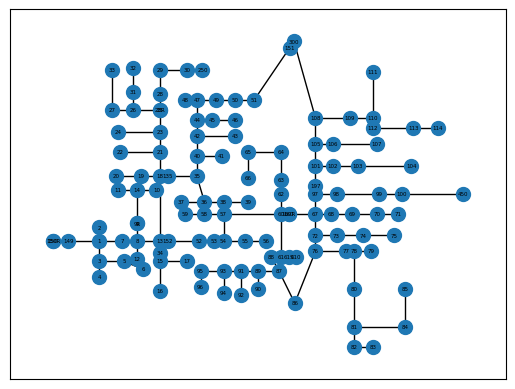

In [84]:
coords_file = f"{output}BusCoords.dat"
pos = {}
with open(coords_file) as f:
    for line in f:
        values = line.split()
        
        # skip comments in file
        if values[0] == "//":
            continue
            
        if len(values) == 3:
            x = float(values[1])
            y = float(values[2])
            pos[values[0].upper()] = (x, y)

options = {
    "font_size": 4,
    "node_size": 100,
    "linewidths": 1,
    "width": 1,
}
nx.draw_networkx(graph, pos, **options)

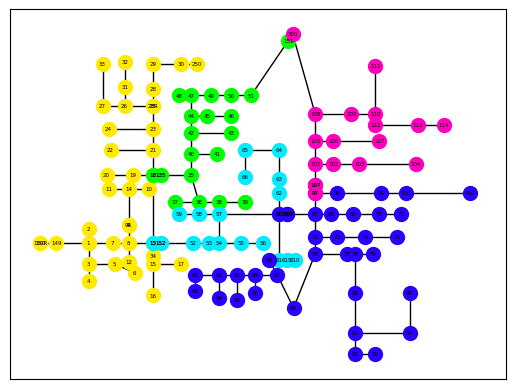

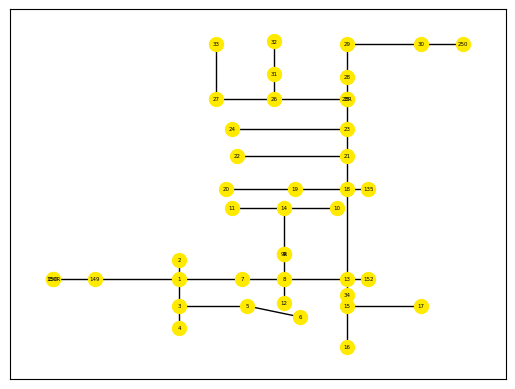

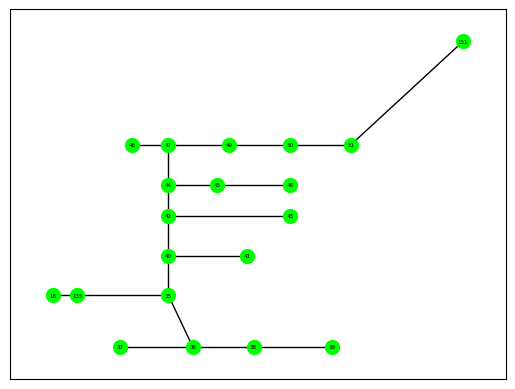

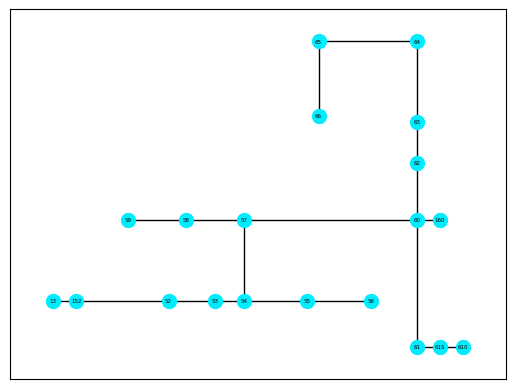

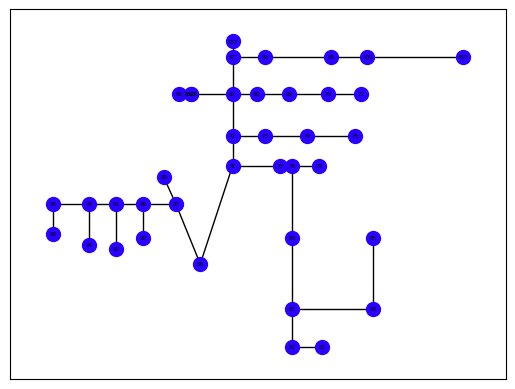

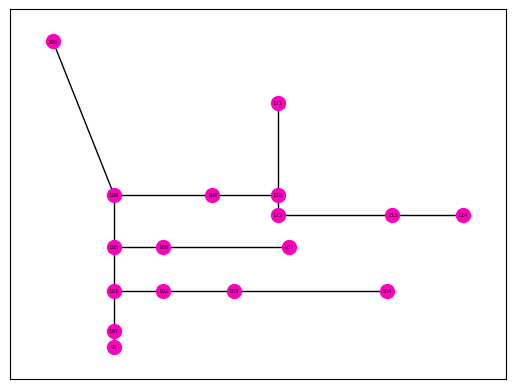

In [96]:
cmap = plt.colormaps["gist_rainbow"]
area_count = len(areas)

fig, ax = plt.subplots()
for i,a in enumerate(areas,1):
    c = cmap(i / area_count)
    nx.draw_networkx(a, pos, **options, node_color=c)

for i,a in enumerate(areas,1):
    c = cmap(i / area_count)
    fig, ax = plt.subplots()
    nx.draw_networkx(a, pos, **options, node_color=c)

## Generate system.json

In [27]:
class Link(BaseModel):
    source: str
    source_port: str
    target: str
    target_port: str


class Component(BaseModel):
    name: str
    federate_type: str
    parameters: dict[str, str]


class System(BaseModel):
    name: str
    components: list[Component]
    links: list[Link]


system = System(name=f"{SCENARIO}_areas", components=[], links=[])
for switch in switches:
    name = switch.name
    if "(" in name or ")" in name:
        name = (
            switch.name[: switch.name.find("(")]
            + "_"
            + switch.name[switch.name.find(")") + 1 :]
        )
    c = Component(
        name=name,
        federate_type="OptimalPowerFlow",
        parameters={"deltat": "0.1", "pf_flag": "true", "control_type": "1"},
    )
    system.components.append(c)

    r_name = f"{name}_recorder_setpoints"
    rec_setpoints = Component(
        name=r_name,
        federate_type="Recorder",
        parameters={
            "feather_filename": f"../../outputs/{SCENARIO}/{r_name}.feather",
            "csv_filename": f"../../outputs/{SCENARIO}/{r_name}.csv",
        },
    )
    system.components.append(rec_setpoints)

    r_name = f"{name}_recorder_real_curtail"
    rec_real = Component(
        name=r_name,
        federate_type="Recorder",
        parameters={
            "feather_filename": f"../../outputs/{SCENARIO}/{r_name}.feather",
            "csv_filename": f"../../outputs/{SCENARIO}/{r_name}.csv",
        },
    )
    system.components.append(rec_real)

    r_name = f"{name}_recorder_forecast_curtail"
    rec_forecast = Component(
        name=r_name,
        federate_type="Recorder",
        parameters={
            "feather_filename": f"../../outputs/{SCENARIO}/{r_name}.feather",
            "csv_filename": f"../../outputs/{SCENARIO}/{r_name}.csv",
        },
    )
    system.components.append(rec_forecast)

    topology = Link(
        source="feeder", source_port="topology", target=c.name, target_port="topology"
    )
    system.links.append(topology)

    injections = Link(
        source="feeder",
        source_port="injections",
        target=c.name,
        target_port="injections",
    )
    system.links.append(injections)

    voltages_magnitude = Link(
        source="feeder",
        source_port="voltages_magnitude",
        target=c.name,
        target_port="voltages_magnitude",
    )
    system.links.append(voltages_magnitude)

    pv_forecast = Link(
        source="feeder",
        source_port="pv_forecast",
        target=c.name,
        target_port="pv_forecast",
    )
    system.links.append(pv_forecast)

    pv_available = Link(
        source="feeder",
        source_port="pv_available",
        target=c.name,
        target_port="pv_available",
    )
    system.links.append(pv_forecast)

    pv_set = Link(
        source=c.name, source_port="pv_set", target="feeder", target_port="pv_set"
    )
    system.links.append(pv_set)

    pv_set = Link(
        source=c.name, source_port="pv_set", target="feeder", target_port="pv_set"
    )
    system.links.append(pv_set)

    pv_set = Link(
        source=c.name,
        source_port="delta_setpoints",
        target=rec_setpoints.name,
        target_port="subscription",
    )
    system.links.append(pv_set)

    pv_set = Link(
        source=c.name,
        source_port="real_curtail",
        target=rec_real.name,
        target_port="subscription",
    )
    system.links.append(pv_set)

    pv_set = Link(
        source=c.name,
        source_port="forecast_curtail",
        target=rec_forecast.name,
        target_port="subscription",
    )
    system.links.append(pv_set)

pprint(system)

System(name='large_areas', components=[Component(name='fuse_p9u_178111', federate_type='OptimalPowerFlow', parameters={'deltat': '0.1', 'pf_flag': 'true', 'control_type': '1'}), Component(name='fuse_p9u_178111_recorder_setpoints', federate_type='Recorder', parameters={'feather_filename': '../../outputs/large/fuse_p9u_178111_recorder_setpoints.feather', 'csv_filename': '../../outputs/large/fuse_p9u_178111_recorder_setpoints.csv'}), Component(name='fuse_p9u_178111_recorder_real_curtail', federate_type='Recorder', parameters={'feather_filename': '../../outputs/large/fuse_p9u_178111_recorder_real_curtail.feather', 'csv_filename': '../../outputs/large/fuse_p9u_178111_recorder_real_curtail.csv'}), Component(name='fuse_p9u_178111_recorder_forecast_curtail', federate_type='Recorder', parameters={'feather_filename': '../../outputs/large/fuse_p9u_178111_recorder_forecast_curtail.feather', 'csv_filename': '../../outputs/large/fuse_p9u_178111_recorder_forecast_curtail.csv'}), Component(name='fuse_

## Run selected scenario
The simulation will take 5-30 minutes to run depending on the scenario. The results will print Done once complete.

In [ ]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: large
[info] Running federate recorder_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate recorder_voltage_real as a background process
[info] Running federate recorder_voltage_imag as a background process
[info] Running federate recorder_voltage_magnitude as a background process
[info] Running federate recorder_opf_voltage_magnitude as a background process
[info] Running federate recorder_delta_setpoint as a background process
[info] Running federate recorder_forecast_curtail as a background process
[info] Running federate recorder_real_curtail as a background process
[info] Running federate feeder as a background process
[info] Running federate lindistflow as a background pro